In [1]:
!git clone https://github.com/rishabh-bhardwaj-64rr/EVA5.git

Cloning into 'EVA5'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 422 (delta 79), reused 21 (delta 2), pack-reused 269
Receiving objects: 100% (422/422), 2.85 MiB | 16.38 MiB/s, done.
Resolving deltas: 100% (207/207), done.


In [2]:
cd EVA5/S10/

/content/EVA5/S10


In [3]:
from __future__ import print_function

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torchsummary import summary

from tqdm import tqdm

import albumentations as A
import albumentations.pytorch.transforms as APT

In [4]:
from data_loading import transform, dataset, dataloader
from models import resnet, cifar10_model
from utils import plot_metrics, misclassifications, classwise_accuracy, show_image
from lr_finder import LRFinder
import normalisation as norm, loss_functions, trainer, tester, run_model
import run_grad_cam

In [5]:
mean = (0.49139968, 0.48215841, 0.44653091)
std = (0.24703223, 0.24348513, 0.26158784)

In [6]:
# train_transforms, test_transforms = transform.cifar10_transforms(mean, std)
train_transforms, test_transforms = transform.cifar10_albumentations(mean, std)
trainset, testset = dataset.cifar10_dataset(train_transforms, test_transforms)
train_loader, test_loader = dataloader.cifar10_dataloader(trainset, testset)
# ToTensorV2()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA available? True


In [7]:
# device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [8]:
# classes in the data
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


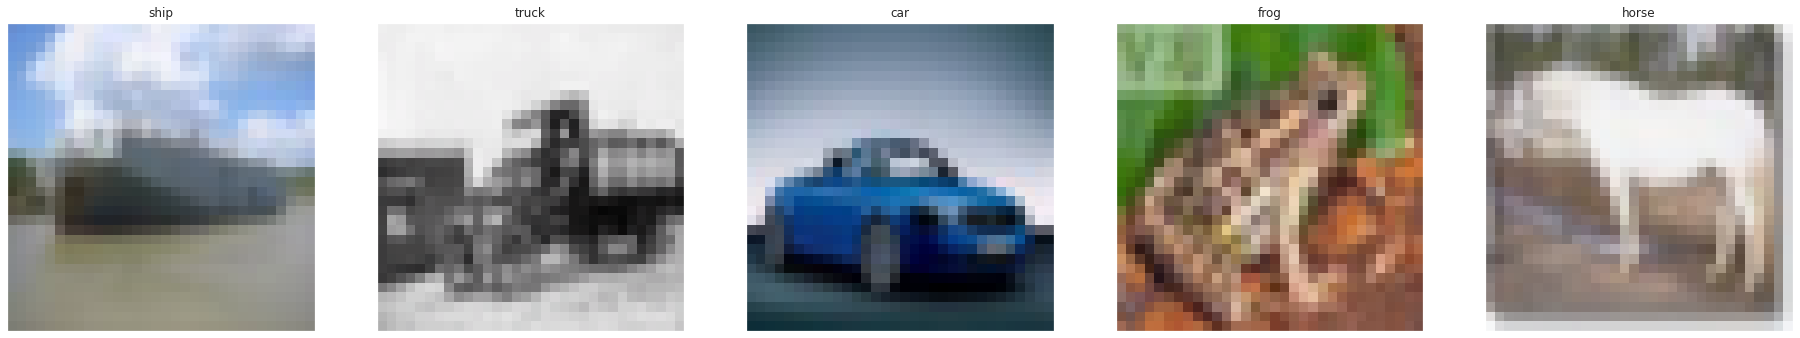

In [9]:
# plotting dataset images(32x32 sized images)
show_image.plot_dataset_images(device, classes, test_loader, mean, std, num_of_images=5)

In [10]:
# model summary
net = resnet.ResNet18().to(device)
print(summary(net, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.23E-02


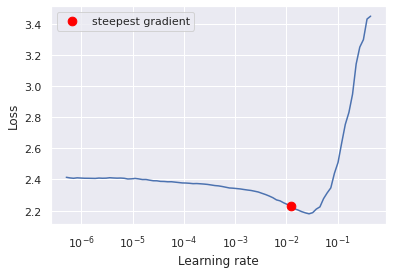

0.02782559402207125


In [11]:
# lr-finder using Leslie Smith's approach(exponential increase in lr)

optimizer = optim.SGD(net.parameters(), lr=1e-7,  momentum=0.9)
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=100)

lr_finder.plot() # loss vs lr curve

# best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
# print(best_lr)

lr_finder.reset()

In [12]:

EPOCHS = 50
optimizer = optim.SGD(net.parameters(), lr = 1.23E-02, momentum = 0.9) # using the lr suggested by lr_finder
scheduler = ReduceLROnPlateau(optimizer, patience = 3)

train_acc = []
train_losses = []
test_acc = []
test_losses = []

run_model.evaluation( net, train_loader, test_loader, optimizer, scheduler, EPOCHS, device,
                    train_acc, train_losses, test_acc, test_losses)


  0%|          | 0/391 [00:00<?, ?it/s]


 Epoch: 1


Loss = 1.2259234189987183 Batch_id = 390 Accuracy = 46.04: 100%|██████████| 391/391 [00:53<00:00,  7.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 6293/10000 (62.93%)


 Epoch: 2


Loss = 1.1437046527862549 Batch_id = 390 Accuracy = 63.51: 100%|██████████| 391/391 [00:54<00:00,  7.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 6205/10000 (62.05%)


 Epoch: 3


Loss = 0.6061122417449951 Batch_id = 390 Accuracy = 70.81: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7349/10000 (73.49%)


 Epoch: 4


Loss = 0.8289912343025208 Batch_id = 390 Accuracy = 75.04: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7499/10000 (74.99%)


 Epoch: 5


Loss = 0.40773695707321167 Batch_id = 390 Accuracy = 77.87: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 7935/10000 (79.35%)


 Epoch: 6


Loss = 0.5742155909538269 Batch_id = 390 Accuracy = 80.22: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8134/10000 (81.34%)


 Epoch: 7


Loss = 0.5785724520683289 Batch_id = 390 Accuracy = 81.57: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8156/10000 (81.56%)


 Epoch: 8


Loss = 0.41176581382751465 Batch_id = 390 Accuracy = 82.99: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8260/10000 (82.60%)


 Epoch: 9


Loss = 0.3485754132270813 Batch_id = 390 Accuracy = 83.90: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8366/10000 (83.66%)


 Epoch: 10


Loss = 0.5964523553848267 Batch_id = 390 Accuracy = 84.88: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8495/10000 (84.95%)


 Epoch: 11


Loss = 0.33777469396591187 Batch_id = 390 Accuracy = 85.70: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8538/10000 (85.38%)


 Epoch: 12


Loss = 0.4434167444705963 Batch_id = 390 Accuracy = 86.62: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8639/10000 (86.39%)


 Epoch: 13


Loss = 0.40817007422447205 Batch_id = 390 Accuracy = 87.65: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8663/10000 (86.63%)


 Epoch: 14


Loss = 0.2992926239967346 Batch_id = 390 Accuracy = 88.02: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8644/10000 (86.44%)


 Epoch: 15


Loss = 0.24103176593780518 Batch_id = 390 Accuracy = 88.62: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8680/10000 (86.80%)


 Epoch: 16


Loss = 0.32737821340560913 Batch_id = 390 Accuracy = 89.22: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8782/10000 (87.82%)


 Epoch: 17


Loss = 0.2722730040550232 Batch_id = 390 Accuracy = 89.88: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8753/10000 (87.53%)


 Epoch: 18


Loss = 0.25035449862480164 Batch_id = 390 Accuracy = 90.05: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8781/10000 (87.81%)


 Epoch: 19


Loss = 0.1388804018497467 Batch_id = 390 Accuracy = 90.86: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8771/10000 (87.71%)


 Epoch: 20


Loss = 0.27460387349128723 Batch_id = 390 Accuracy = 90.98: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8795/10000 (87.95%)


 Epoch: 21


Loss = 0.17442871630191803 Batch_id = 390 Accuracy = 91.56: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8801/10000 (88.01%)


 Epoch: 22


Loss = 0.2588987350463867 Batch_id = 390 Accuracy = 91.80: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8855/10000 (88.55%)


 Epoch: 23


Loss = 0.26716431975364685 Batch_id = 390 Accuracy = 92.24: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8822/10000 (88.22%)


 Epoch: 24


Loss = 0.12021331489086151 Batch_id = 390 Accuracy = 94.30: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9089/10000 (90.89%)


 Epoch: 25


Loss = 0.2339417189359665 Batch_id = 390 Accuracy = 95.08: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9121/10000 (91.21%)


 Epoch: 26


Loss = 0.05549978092312813 Batch_id = 390 Accuracy = 95.38: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9134/10000 (91.34%)


 Epoch: 27


Loss = 0.10842801630496979 Batch_id = 390 Accuracy = 95.61: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9135/10000 (91.35%)


 Epoch: 28


Loss = 0.1275029182434082 Batch_id = 390 Accuracy = 95.74: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9128/10000 (91.28%)


 Epoch: 29


Loss = 0.13997119665145874 Batch_id = 390 Accuracy = 96.03: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9137/10000 (91.37%)


 Epoch: 30


Loss = 0.06585662066936493 Batch_id = 390 Accuracy = 96.01: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9140/10000 (91.40%)


 Epoch: 31


Loss = 0.21380643546581268 Batch_id = 390 Accuracy = 96.23: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9153/10000 (91.53%)


 Epoch: 32


Loss = 0.06861114501953125 Batch_id = 390 Accuracy = 96.10: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9163/10000 (91.63%)


 Epoch: 33


Loss = 0.1299317181110382 Batch_id = 390 Accuracy = 96.23: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9168/10000 (91.68%)


 Epoch: 34


Loss = 0.09319613128900528 Batch_id = 390 Accuracy = 96.24: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9162/10000 (91.62%)


 Epoch: 35


Loss = 0.11021365970373154 Batch_id = 390 Accuracy = 96.22: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9161/10000 (91.61%)


 Epoch: 36


Loss = 0.1880638152360916 Batch_id = 390 Accuracy = 96.22: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9151/10000 (91.51%)


 Epoch: 37


Loss = 0.061614252626895905 Batch_id = 390 Accuracy = 96.20: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9162/10000 (91.62%)


 Epoch: 38


Loss = 0.12404092401266098 Batch_id = 390 Accuracy = 96.24: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9153/10000 (91.53%)


 Epoch: 39


Loss = 0.04045260697603226 Batch_id = 390 Accuracy = 96.38: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9163/10000 (91.63%)


 Epoch: 40


Loss = 0.1507454812526703 Batch_id = 390 Accuracy = 96.27: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9165/10000 (91.65%)


 Epoch: 41


Loss = 0.05367400124669075 Batch_id = 390 Accuracy = 96.25: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9165/10000 (91.65%)


 Epoch: 42


Loss = 0.05818120390176773 Batch_id = 390 Accuracy = 96.27: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9158/10000 (91.58%)


 Epoch: 43


Loss = 0.18694467842578888 Batch_id = 390 Accuracy = 96.14: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9149/10000 (91.49%)


 Epoch: 44


Loss = 0.08979929983615875 Batch_id = 390 Accuracy = 96.32: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9158/10000 (91.58%)


 Epoch: 45


Loss = 0.09873931854963303 Batch_id = 390 Accuracy = 96.24: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9151/10000 (91.51%)


 Epoch: 46


Loss = 0.05148272588849068 Batch_id = 390 Accuracy = 96.34: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9160/10000 (91.60%)


 Epoch: 47


Loss = 0.09084238857030869 Batch_id = 390 Accuracy = 96.28: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9163/10000 (91.63%)


 Epoch: 48


Loss = 0.18257023394107819 Batch_id = 390 Accuracy = 96.40: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9151/10000 (91.51%)


 Epoch: 49


Loss = 0.06415955722332001 Batch_id = 390 Accuracy = 96.25: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9155/10000 (91.55%)


 Epoch: 50


Loss = 0.03360864520072937 Batch_id = 390 Accuracy = 96.42: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]



Test set: Average loss: 0.0023, Accuracy: 9151/10000 (91.51%)



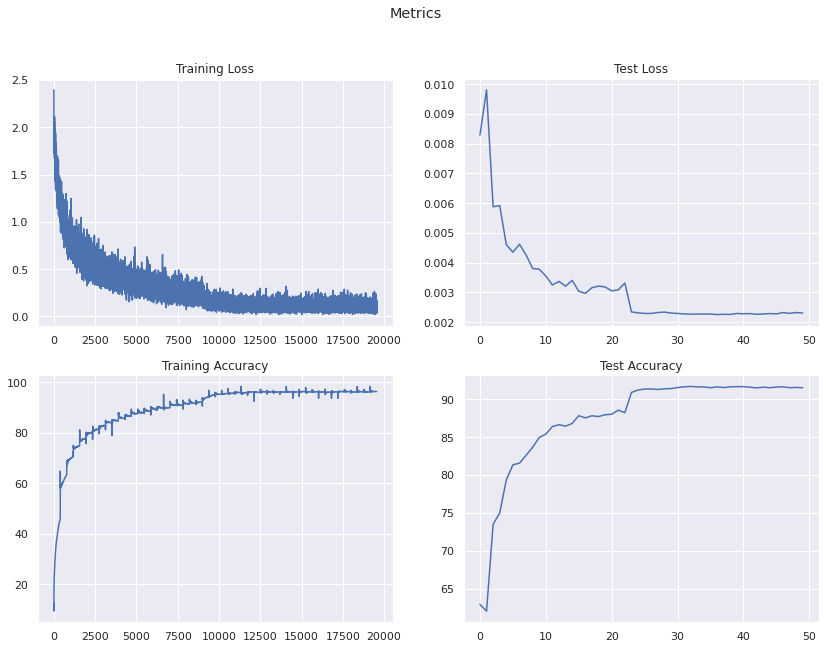

In [14]:
train_metric = (train_acc, train_losses)
test_metric = (test_acc, test_losses)

plot_metrics.metrics(train_metric, test_metric)


In [15]:
# # grad-cam
# target_layers = ["layer1", "layer2", "layer3", "layer4"]
# run_grad_cam.plot_gradcam(net, device, test_loader, classes, target_layers, mean, std)

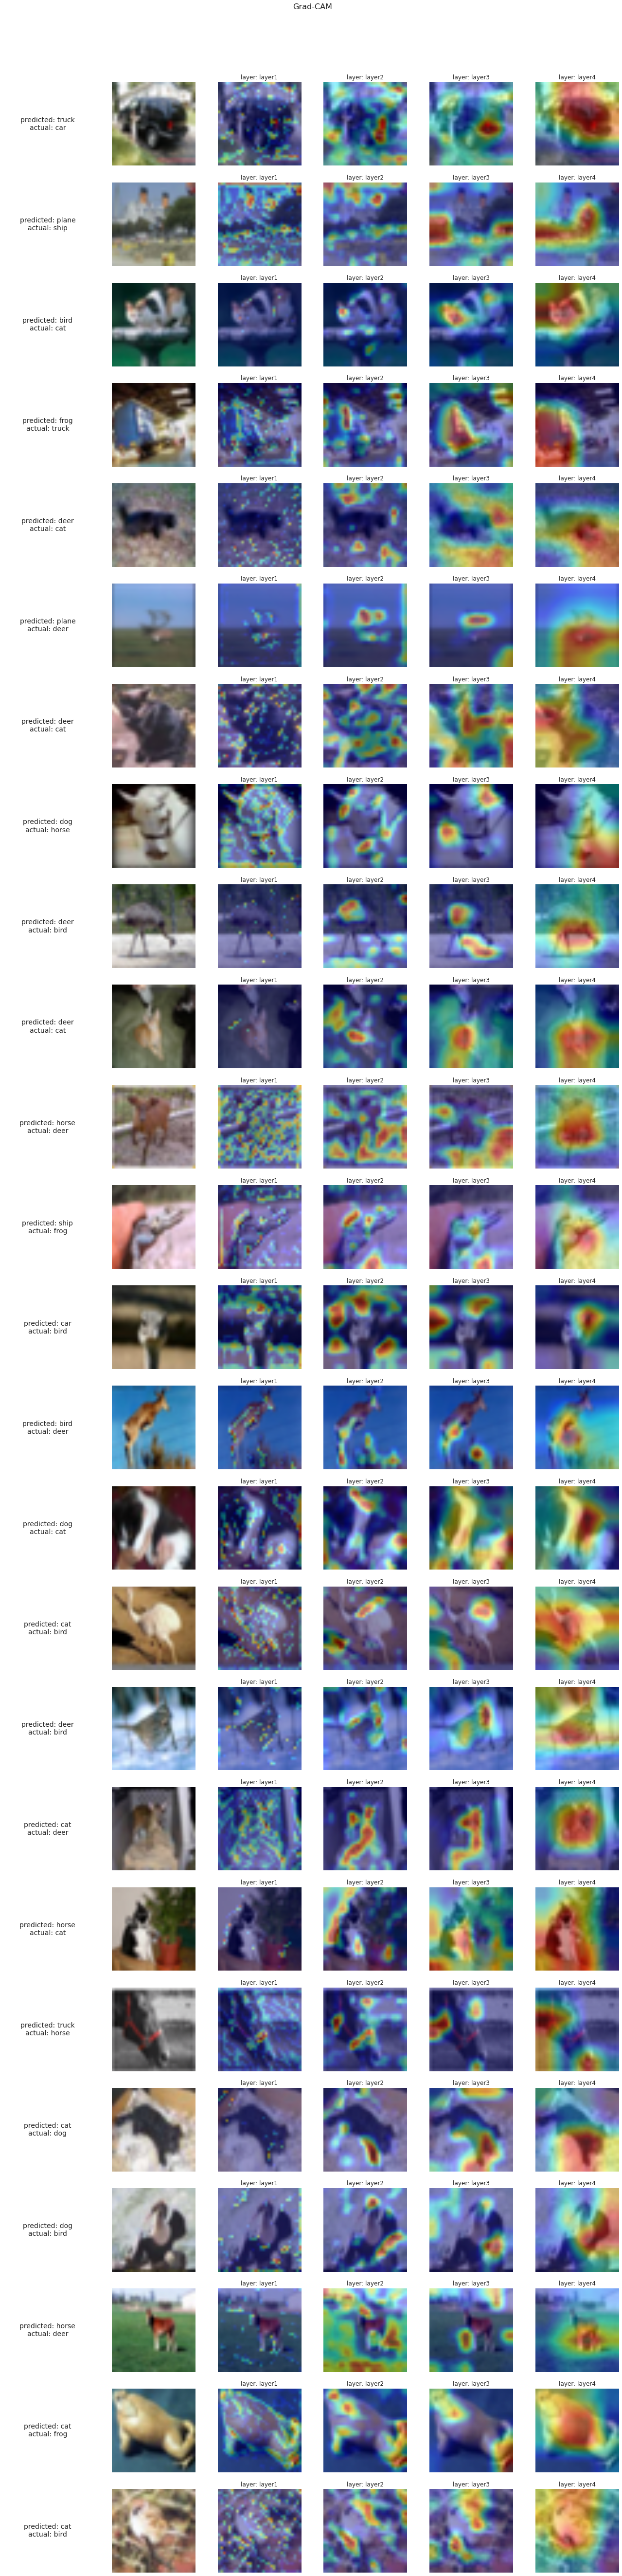

In [16]:
# grad-cam on misclassified images
target_layers = ["layer1", "layer2", "layer3", "layer4"]
run_grad_cam.plot_gradcam_misclassified(net, test_loader, device, classes, target_layers, mean, std, num_images = 25)

In [17]:
# classwise accuracy
classwise_accuracy.classwise_accuracy(net, test_loader, device, classes)

Accuracy of plane : 89 %
Accuracy of   car : 97 %
Accuracy of  bird : 80 %
Accuracy of   cat : 88 %
Accuracy of  deer : 81 %
Accuracy of   dog : 82 %
Accuracy of  frog : 100 %
Accuracy of horse : 91 %
Accuracy of  ship : 97 %
Accuracy of truck : 100 %
